In [1]:
import glob
import logging
from multiprocessing import Pool
import os
import sys

from astropy.io import fits
import numpy as np
import tempfile
import threading
from threading import Thread
from photutils import DAOStarFinder


from pyql.database.ql_database_interface import session
from pyql.database.ql_database_interface import Master
from pyql.database.ql_database_interface import IR_flt_0

In [29]:
#test data:
import numpy as np
from astropy.io import fits 
file='/grp/hst/wfc3a/GO_Links/12167/Visit02/ibhg02q2q_flt.fits'
#file='/grp/hst/wfc3f/QL_GO/12025/Visit08/ibg808jxq_flt.fits'
hdulist=fits.open(file)
data=hdulist[1].data
data1=hdulist[1].data
data2=hdulist[1].data
data3=hdulist[1].data
hdulist.close()

In [30]:
import scipy
from scipy.stats import sigmaclip
from scipy.ndimage import gaussian_filter

clip,low,high=sigmaclip(data)
s=clip.std()

k = np.array([[1,1,1],[1,1,1],[1,1,1]])
from scipy import ndimage
data_con=ndimage.convolve(data, k, mode='constant', cval=0.0)

[[  0   0   0 ...,   2   2   2]
 [  0   0   0 ...,   2   2   2]
 [  0   0   0 ...,   2   2   2]
 ..., 
 [732 732 732 ..., 740 740 740]
 [732 732 732 ..., 740 740 740]
 [732 732 732 ..., 740 740 740]]
[[   0    0    0 ...,    2    2    2]
 [   0    0    0 ...,    2    2    2]
 [   0    0    0 ...,    2    2    2]
 ..., 
 [1049 1049 1049 ..., 1063 1063 1063]
 [1049 1049 1049 ..., 1063 1063 1063]
 [1049 1049 1049 ..., 1063 1063 1063]]


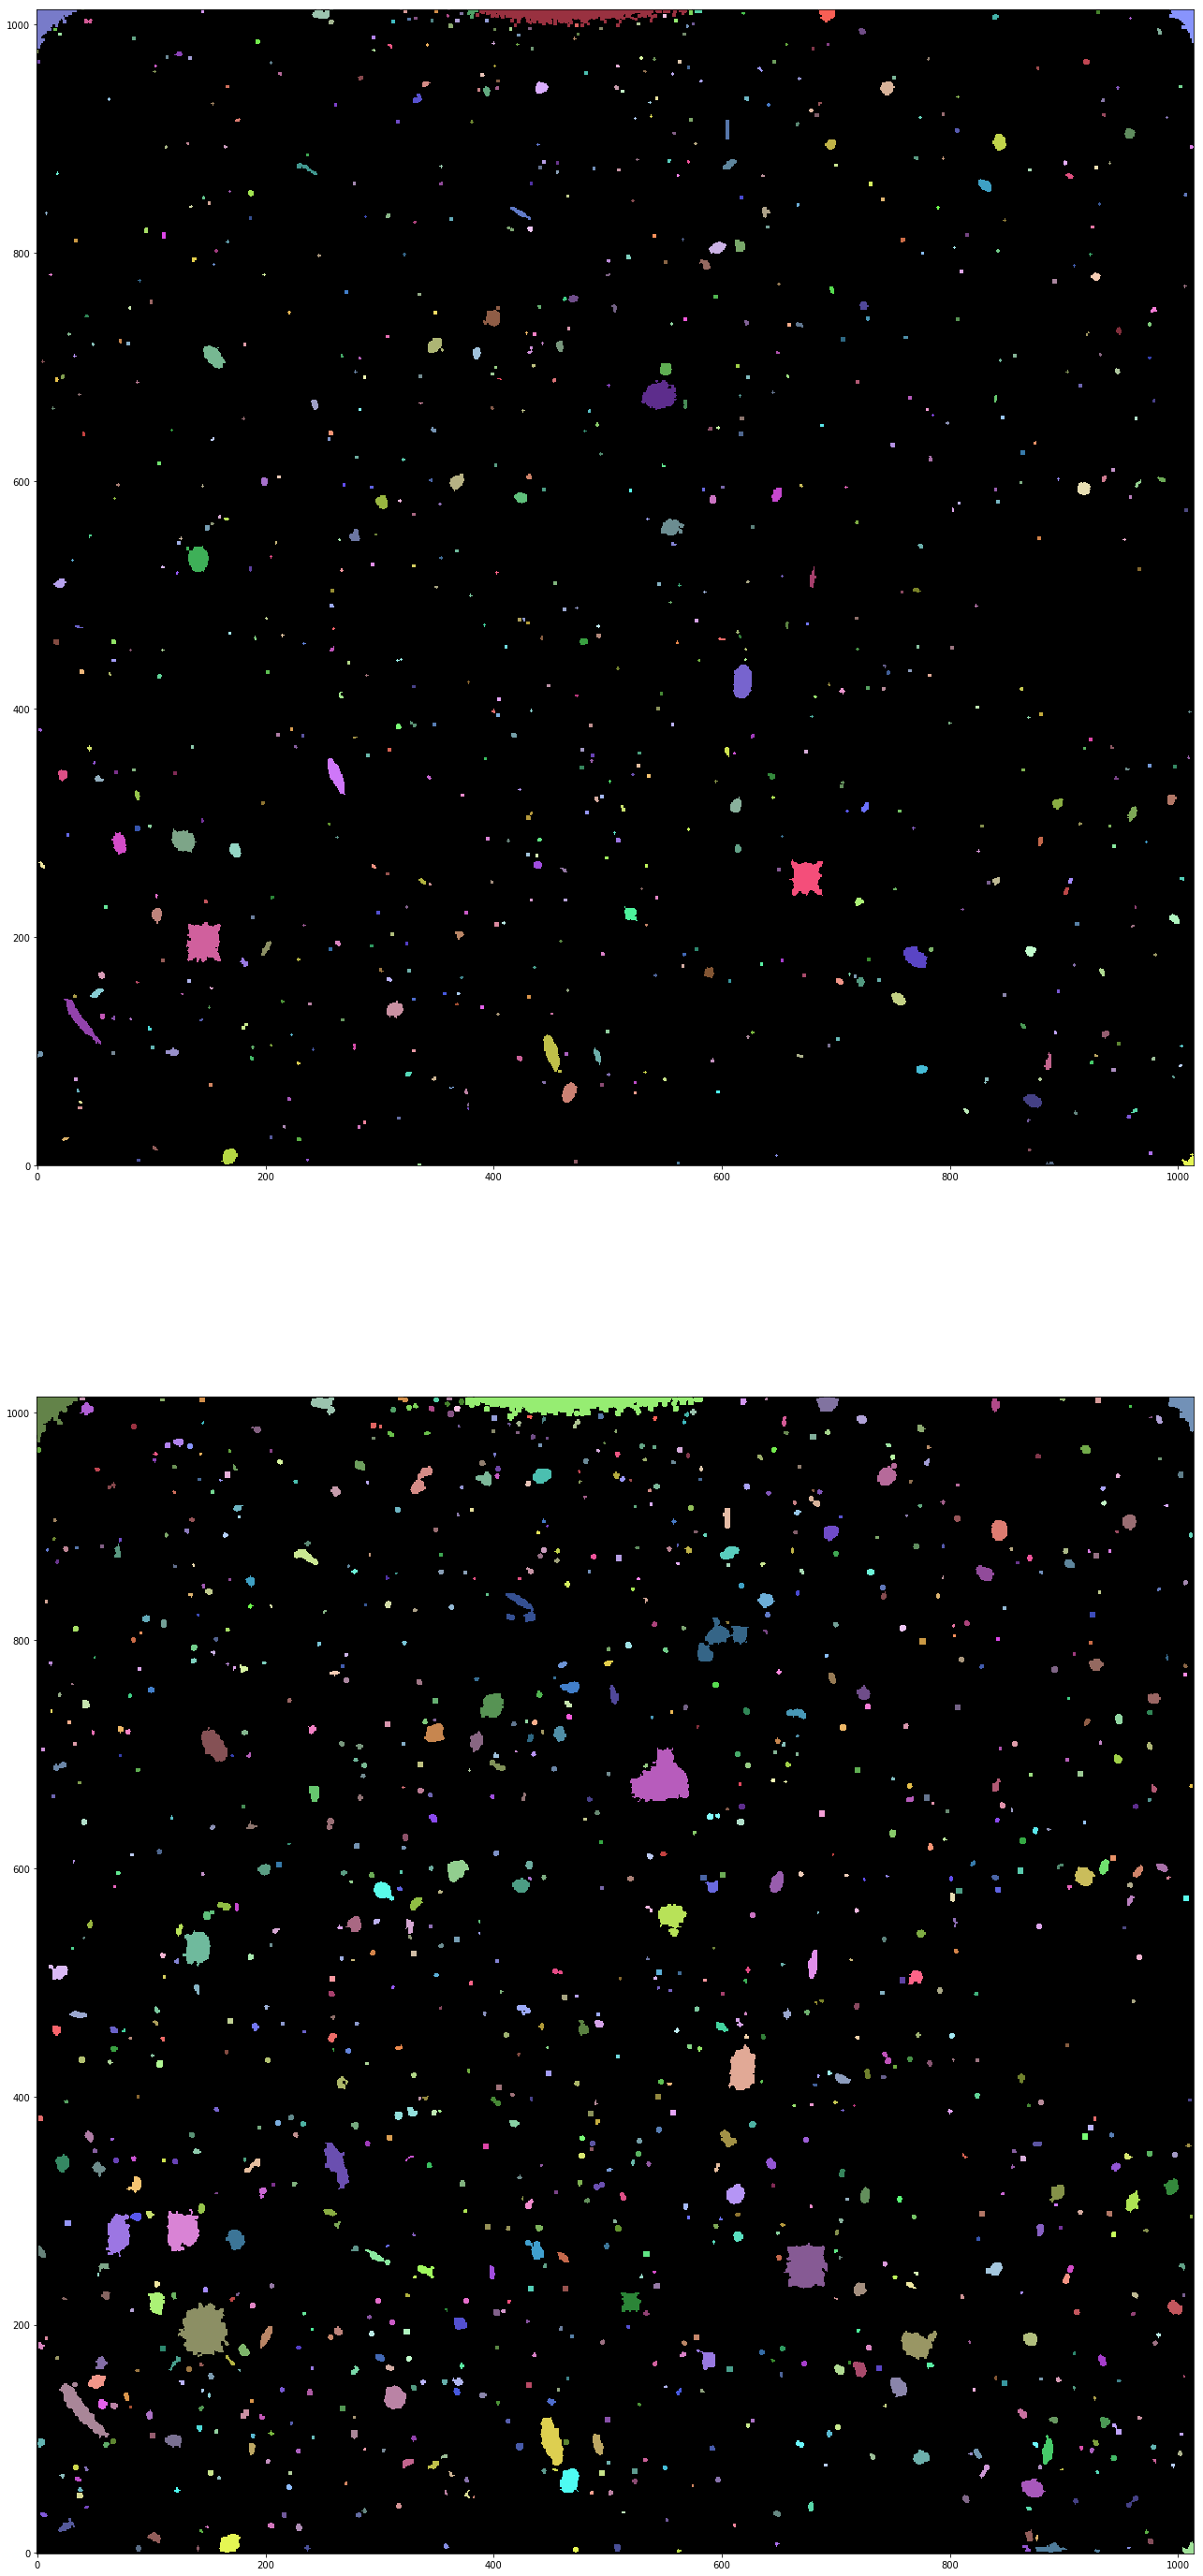

In [31]:
%matplotlib inline
import numpy as np
from astropy.io import fits
#data=np.array([[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.],[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.],[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.],[1.,1.,1.,1.,1.,26.,1.,1.,1.,1.,1.,1.,1.,20.,1.],[1.,1.,1.,1.,20.,30.,15.,1.,1.,1.,1.,1.,15.,56.,10.],[1.,1.,1.,1.,1.,20.,1.,1.,1.,1.,1.,1.,8.,20.,5.],[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.],[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.],[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]])
#hdulist=fits.open(locales[3])
#data=hdulist[1].data
#hdulist.close()
from photutils import detect_threshold
threshold = detect_threshold(data, snr=3.)
threshold_con = detect_threshold(data_con, snr=3.)
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
sigma = 2.0 * gaussian_fwhm_to_sigma    # FWHM = 2.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)
segm_con = detect_sources(data_con, threshold_con, npixels=5, filter_kernel=kernel)

import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 50))
ax1.imshow(segm, origin='lower',cmap=segm.cmap(random_state=12345))# cmap='Greys_r', norm=norm)
ax2.imshow(segm_con, origin='lower', cmap=segm.cmap(random_state=12345))
print(segm.array)
print(segm_con.array)

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import morphology
sq = morphology.square(width=5)
dia = morphology.diamond(radius=1)
print(sq)
print(dia)


[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
[[0 1 0]
 [1 1 1]
 [0 1 0]]


In [15]:
mask=morphology.dilation(segm, sq)

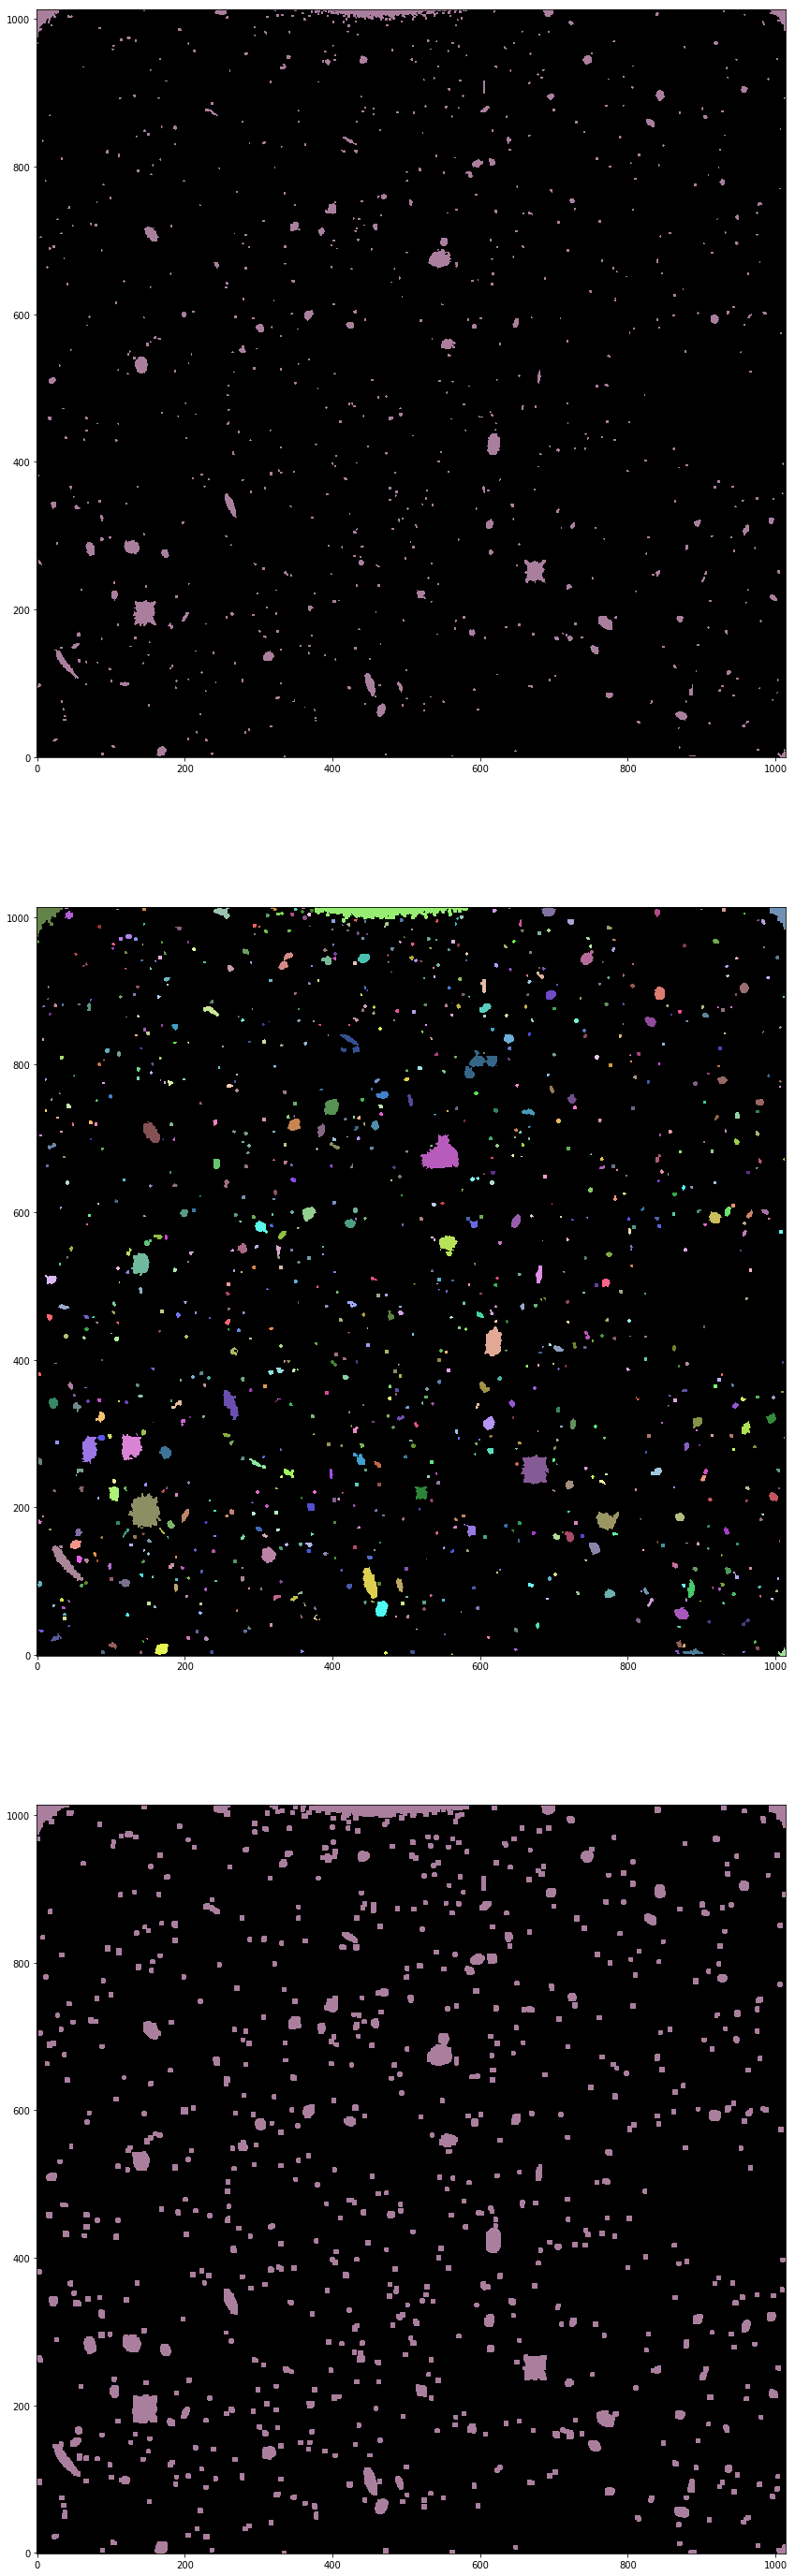

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(50, 50))
ax1.imshow(segm, origin='lower',cmap=segm.cmap(random_state=12345))# cmap='Greys_r', norm=norm)
ax2.imshow(segm_con, origin='lower', cmap=segm.cmap(random_state=12345))
ax3.imshow(mask, origin='lower', cmap=segm.cmap(random_state=12345))
#print(segm.array)

In [17]:
dq=fits.getdata(file, ext=3)
#print(dq)
bit_mask = (4+16+32+128+512)
dq0 = np.bitwise_and(dq,np.zeros(np.shape(dq),'Int16')+ bit_mask)
dq0==0
dq0[dq0>0]=1
#data_grown[dq0!=0]=np.nan
print(dq0)

mask[dq0>0]=1
#print(data_grown)
data[mask>0]=np.nan
print(data)


dq=fits.getdata(file, ext=3)
#print(dq)
bit_mask = (4+16+32+128+512)
dq0 = np.bitwise_and(dq,np.zeros(np.shape(dq),'Int16')+ bit_mask)
dq0==0
dq0[dq0>0.0]=1.0
#data_grown[dq0!=0]=np.nan
print(dq0)
seg_arr=segm_con.array
seg_arr[seg_arr>0]=1.0
seg_arr[dq0>0.0]=1.0
#print(data_grown)
data1[seg_arr>0.0]=np.nan
print(data1)

[[0 0 0 ..., 1 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]
[[ 1.62701225  1.55093789  1.66726983 ...,         nan         nan
          nan]
 [ 1.5884968   1.60734856  1.70579147 ...,         nan         nan
          nan]
 [ 1.60153186  1.55686224  1.65795505 ...,         nan         nan
          nan]
 ..., 
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]]
[[0 0 0 ..., 1 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]
[[ 1.62701225  1.55093789  1.66726983 ...,         nan         nan
          nan]
 [ 1.5884968   1.60734856  1.70579147 ...,         nan         nan
          nan]
 [ 1.60153186  1.55686224  1.65795505 ...,         nan         nan
          nan

/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


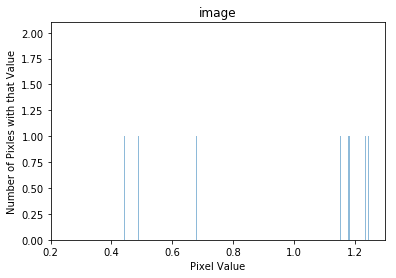

In [18]:
n, b, histogram=plt.hist(data.ravel(), bins=1000, range=(0.25, 1.25), alpha=.5)
plt.xlabel('Pixel Value')
plt.ylabel('Number of Pixles with that Value')
plt.title('image')
plt.legend(loc='upper right')

/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


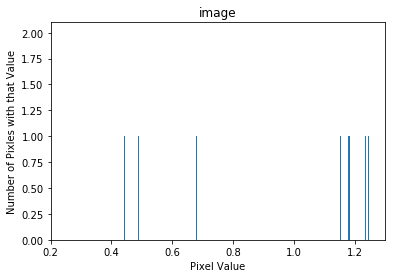

In [19]:
n, b, histogram=plt.hist(data1.ravel(), bins=1000, range=(0.25, 1.25))#, alpha=.5)
plt.xlabel('Pixel Value')
plt.ylabel('Number of Pixles with that Value')
plt.title('image')
plt.legend(loc='upper right')

/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


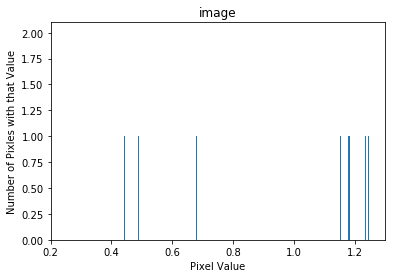

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

n, b, histogram=plt.hist(data2.ravel(), bins=1000, range=(0.25, 1.25))#, alpha=.5)
plt.xlabel('Pixel Value')
plt.ylabel('Number of Pixles with that Value')
plt.title('image')
plt.legend(loc='upper right')

In [32]:
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian2DKernel

In [33]:
gauss = Gaussian2DKernel(stddev=2)

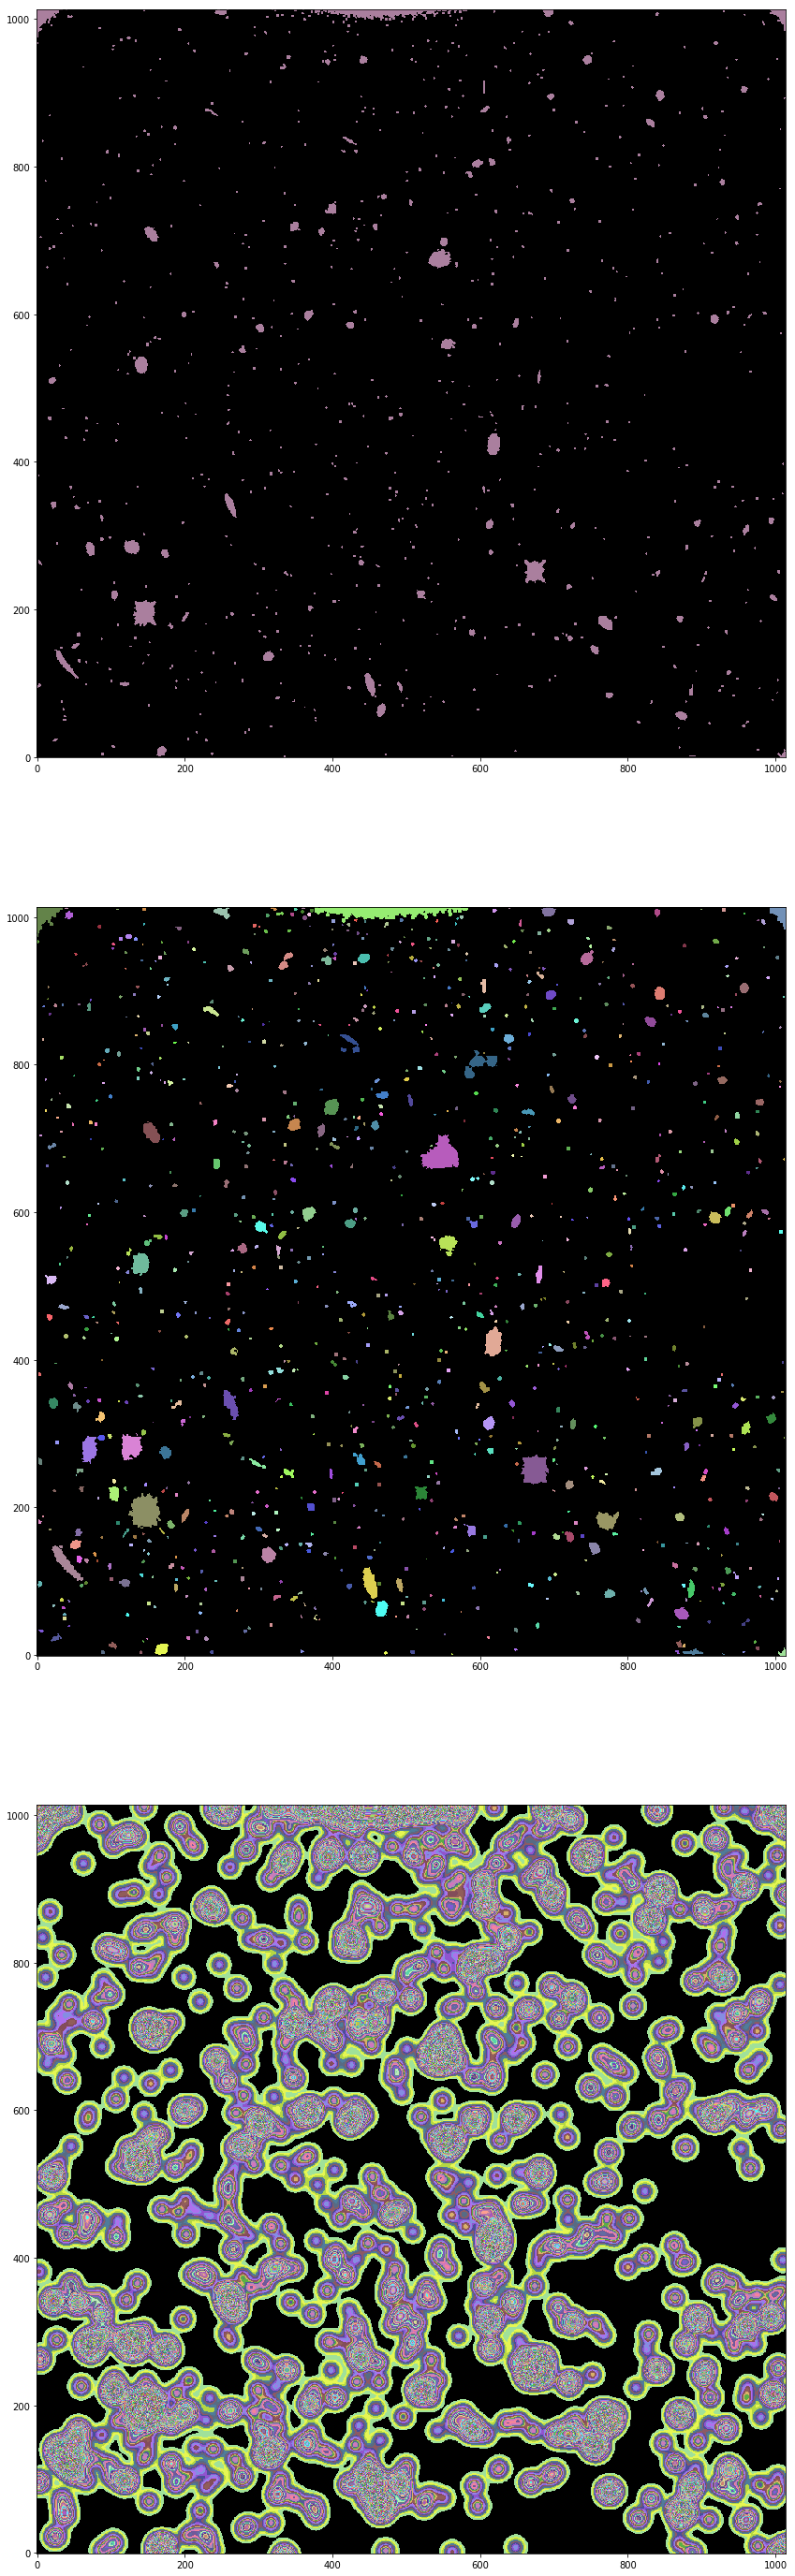

In [35]:
import numpy as np
import matplotlib.pyplot as plt

segm_arr=segm.array
segm_arr[segm_arr>0]=1.0
#segm_arr[dq0>0]=1

# Create kernel
g = Gaussian2DKernel(stddev=8)

# Convolve data
z = convolve(segm_arr, g, boundary='extend')

# Plot data before and after convolution
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(50, 50))
ax1.imshow(segm, origin='lower',cmap=segm.cmap(random_state=12345))# cmap='Greys_r', norm=norm)
ax2.imshow(segm_con, origin='lower', cmap=segm.cmap(random_state=12345))
#ax3.imshow(mask, origin='lower', cmap=segm.cmap(random_state=12345))
ax3.imshow(z, origin='lower', cmap=segm.cmap(random_state=12345))
#print(segm.array)

In [16]:
print(z)

[[ 0.01340157  0.01481934  0.01613756 ...,  0.57004496  0.60372877
   0.63500496]
 [ 0.01414684  0.01564345  0.01703492 ...,  0.5408113   0.5733892
   0.60372318]
 [ 0.01470442  0.01626     0.01770627 ...,  0.50948757  0.54079004
   0.57001831]
 ..., 
 [ 0.9131875   0.90846914  0.90317048 ...,  0.94361669  0.95378447
   0.96235265]
 [ 0.91947462  0.91392552  0.90781897 ...,  0.95109111  0.96026805
   0.96792549]
 [ 0.92457335  0.91825726  0.91140017 ...,  0.95749028  0.96579191
   0.9726483 ]]


In [36]:
z[z>0.003]=1
z[z<0.003]=0
print(z)

[[ 0.  0.  0. ...,  1.  1.  1.]
 [ 0.  0.  0. ...,  1.  1.  1.]
 [ 0.  0.  0. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


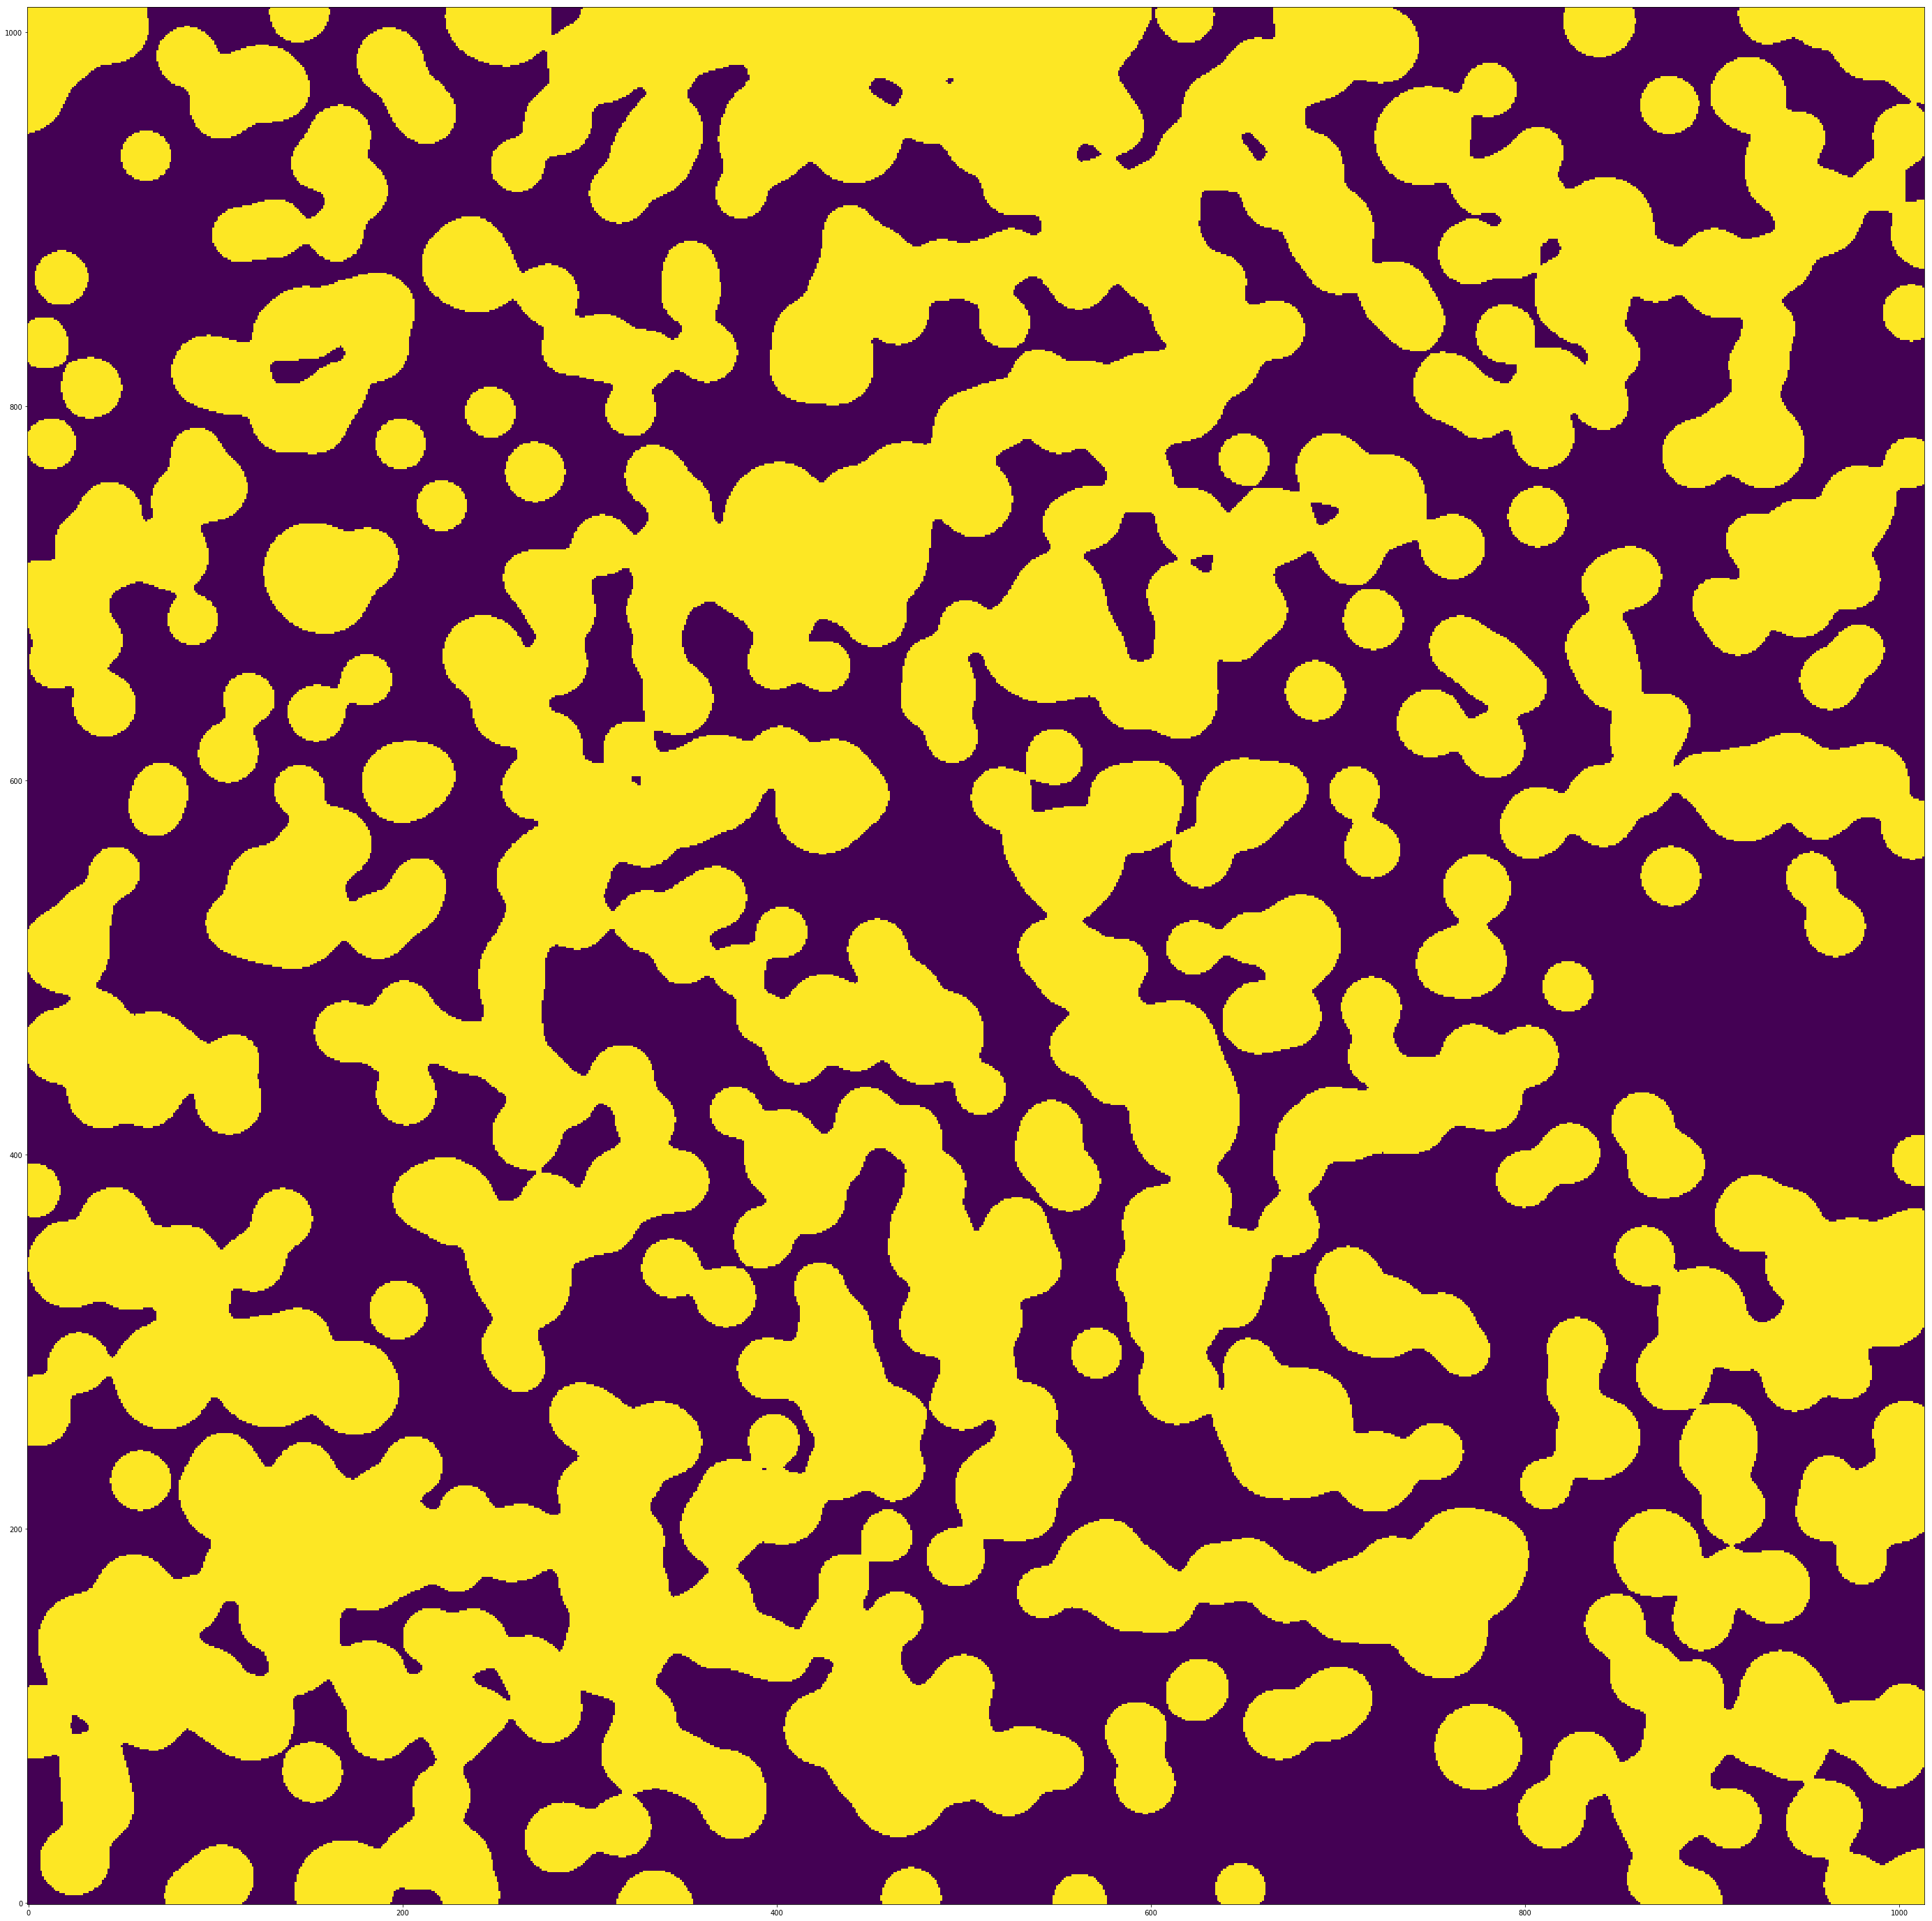

In [37]:
fig, (ax1) = plt.subplots(1, 1, figsize=(50, 50))
ax1.imshow(z, origin='lower')#,cmap=segm.cmap(random_state=12345))

In [38]:
dq=fits.getdata(file, ext=3)
#print(dq)
bit_mask = (4+16+32+128+512)
dq0 = np.bitwise_and(dq,np.zeros(np.shape(dq),'Int16')+ bit_mask)
dq0==0
dq0[dq0>0.0]=1.0
#data_grown[dq0!=0]=np.nan
#print(dq0)
#seg_arr=segm_con.array
#z[z>0.003]=1
z[dq0>0.0]=1.0
#print(data_grown)
data3[z>0.0]=np.nan
print(data3)

[[ 1.62701225  1.55093789  1.66726983 ...,         nan         nan
          nan]
 [ 1.5884968   1.60734856  1.70579147 ...,         nan         nan
          nan]
 [ 1.60153186  1.55686224  1.65795505 ...,         nan         nan
          nan]
 ..., 
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]
 [        nan         nan         nan ...,         nan         nan
          nan]]


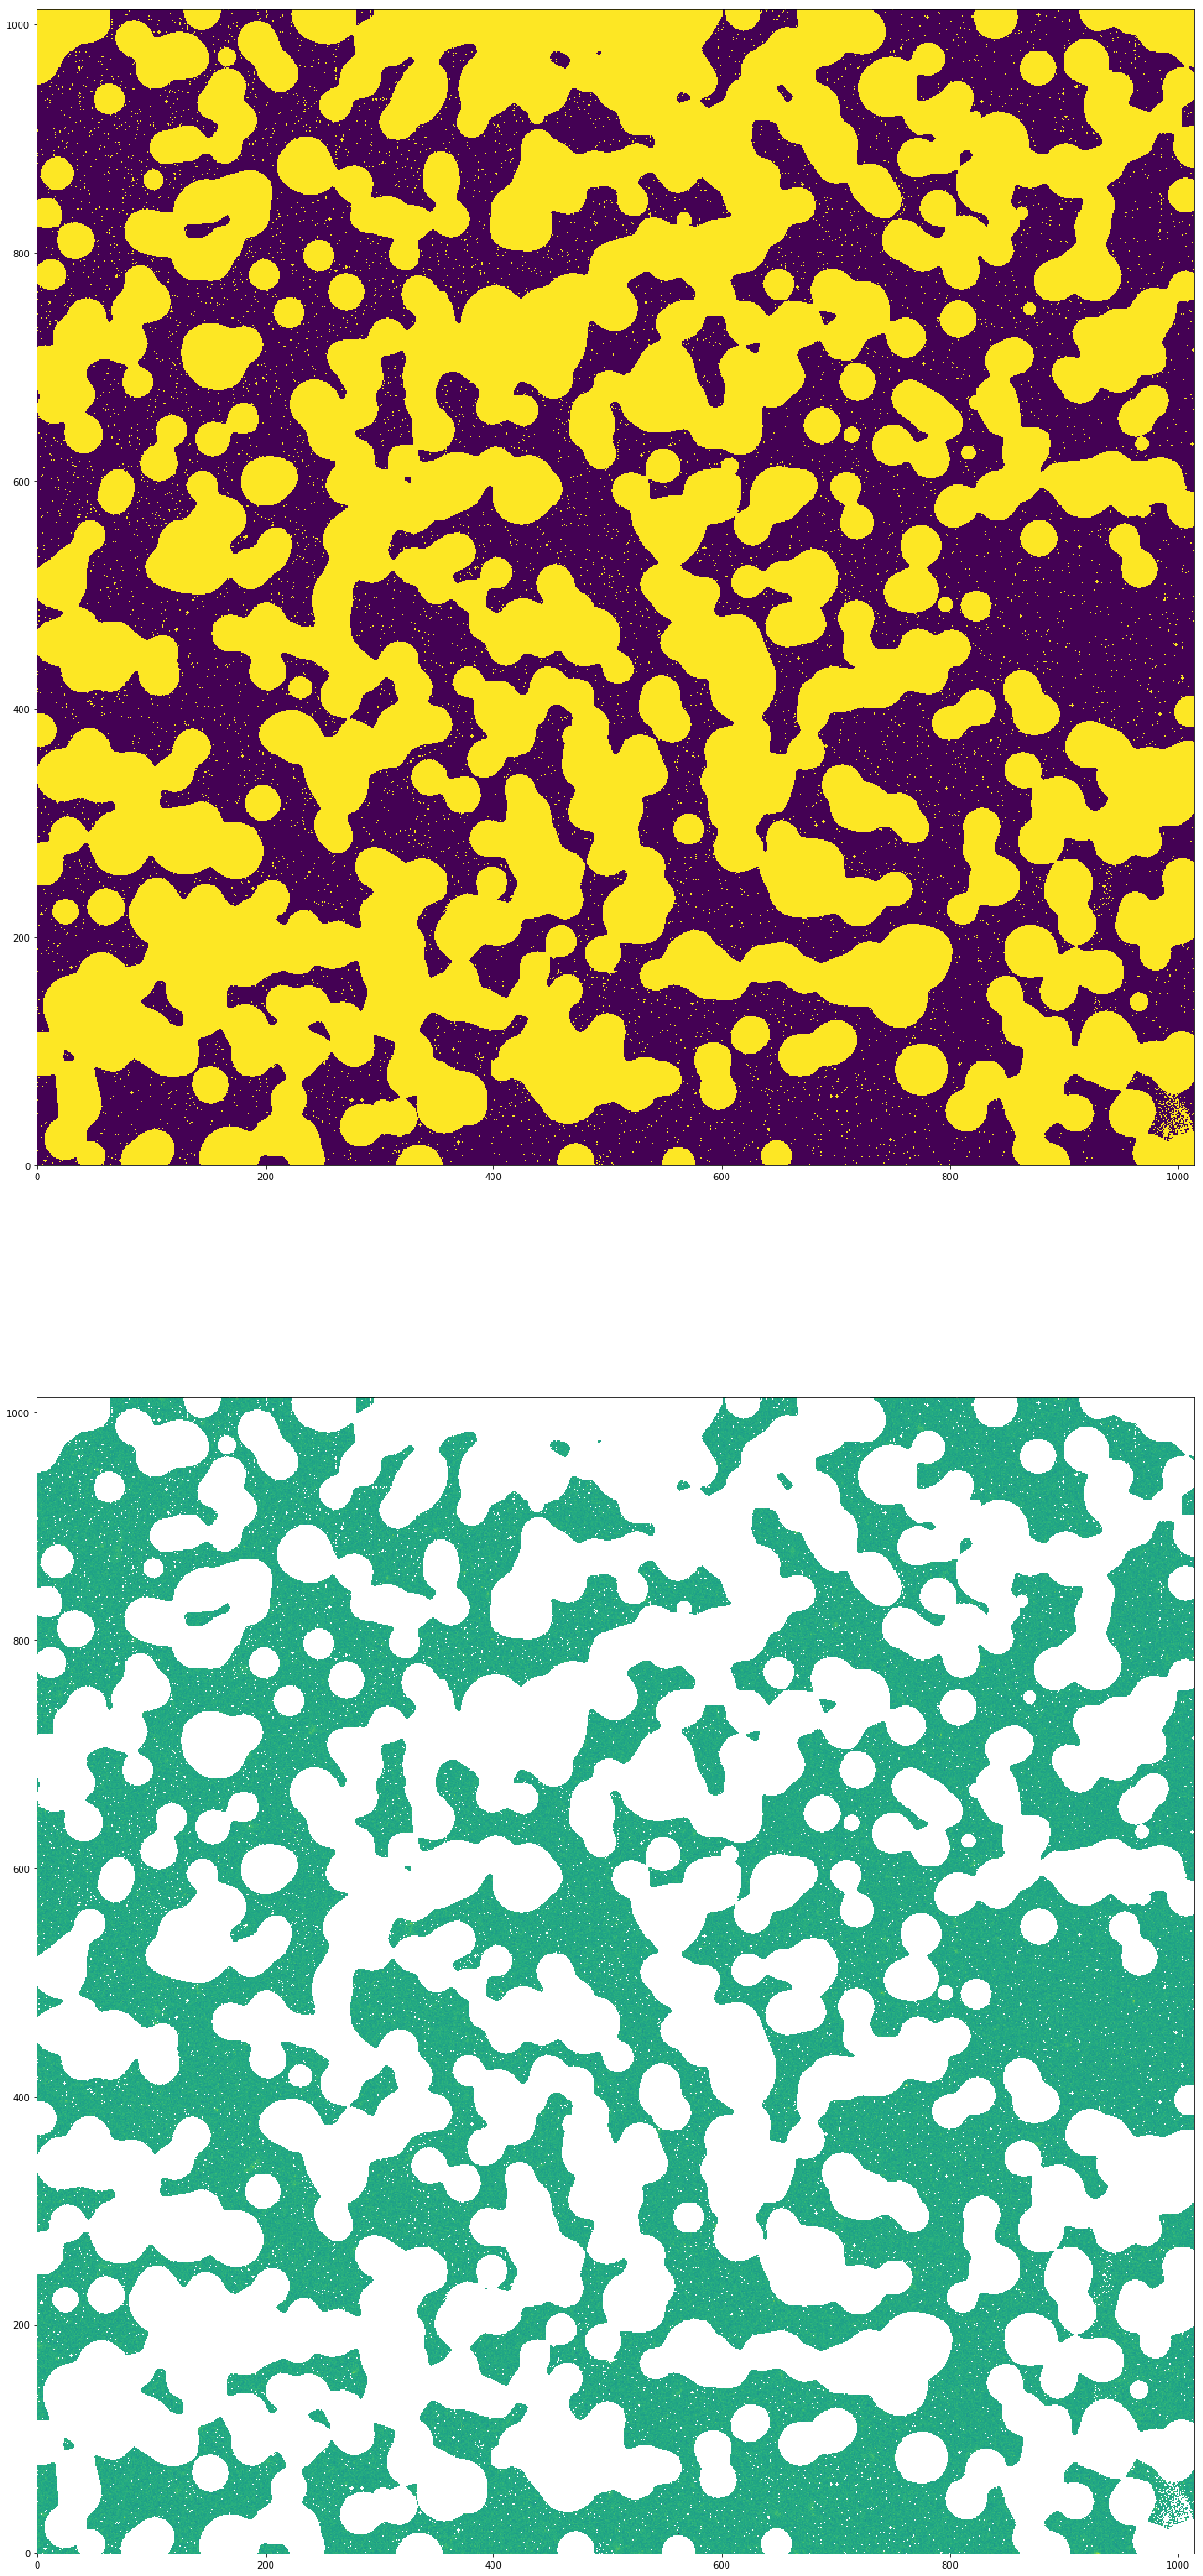

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 50))
ax1.imshow(z, origin='lower')
ax2.imshow(data3, origin='lower')

/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


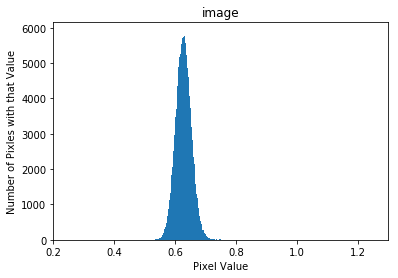

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

n, b, histogram=plt.hist(data3.ravel(), bins=1000, range=(0.25, 1.25))#, alpha=.5)
plt.xlabel('Pixel Value')
plt.ylabel('Number of Pixles with that Value')
plt.title('image')
plt.legend(loc='upper right')

/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/Users/hkurtz/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


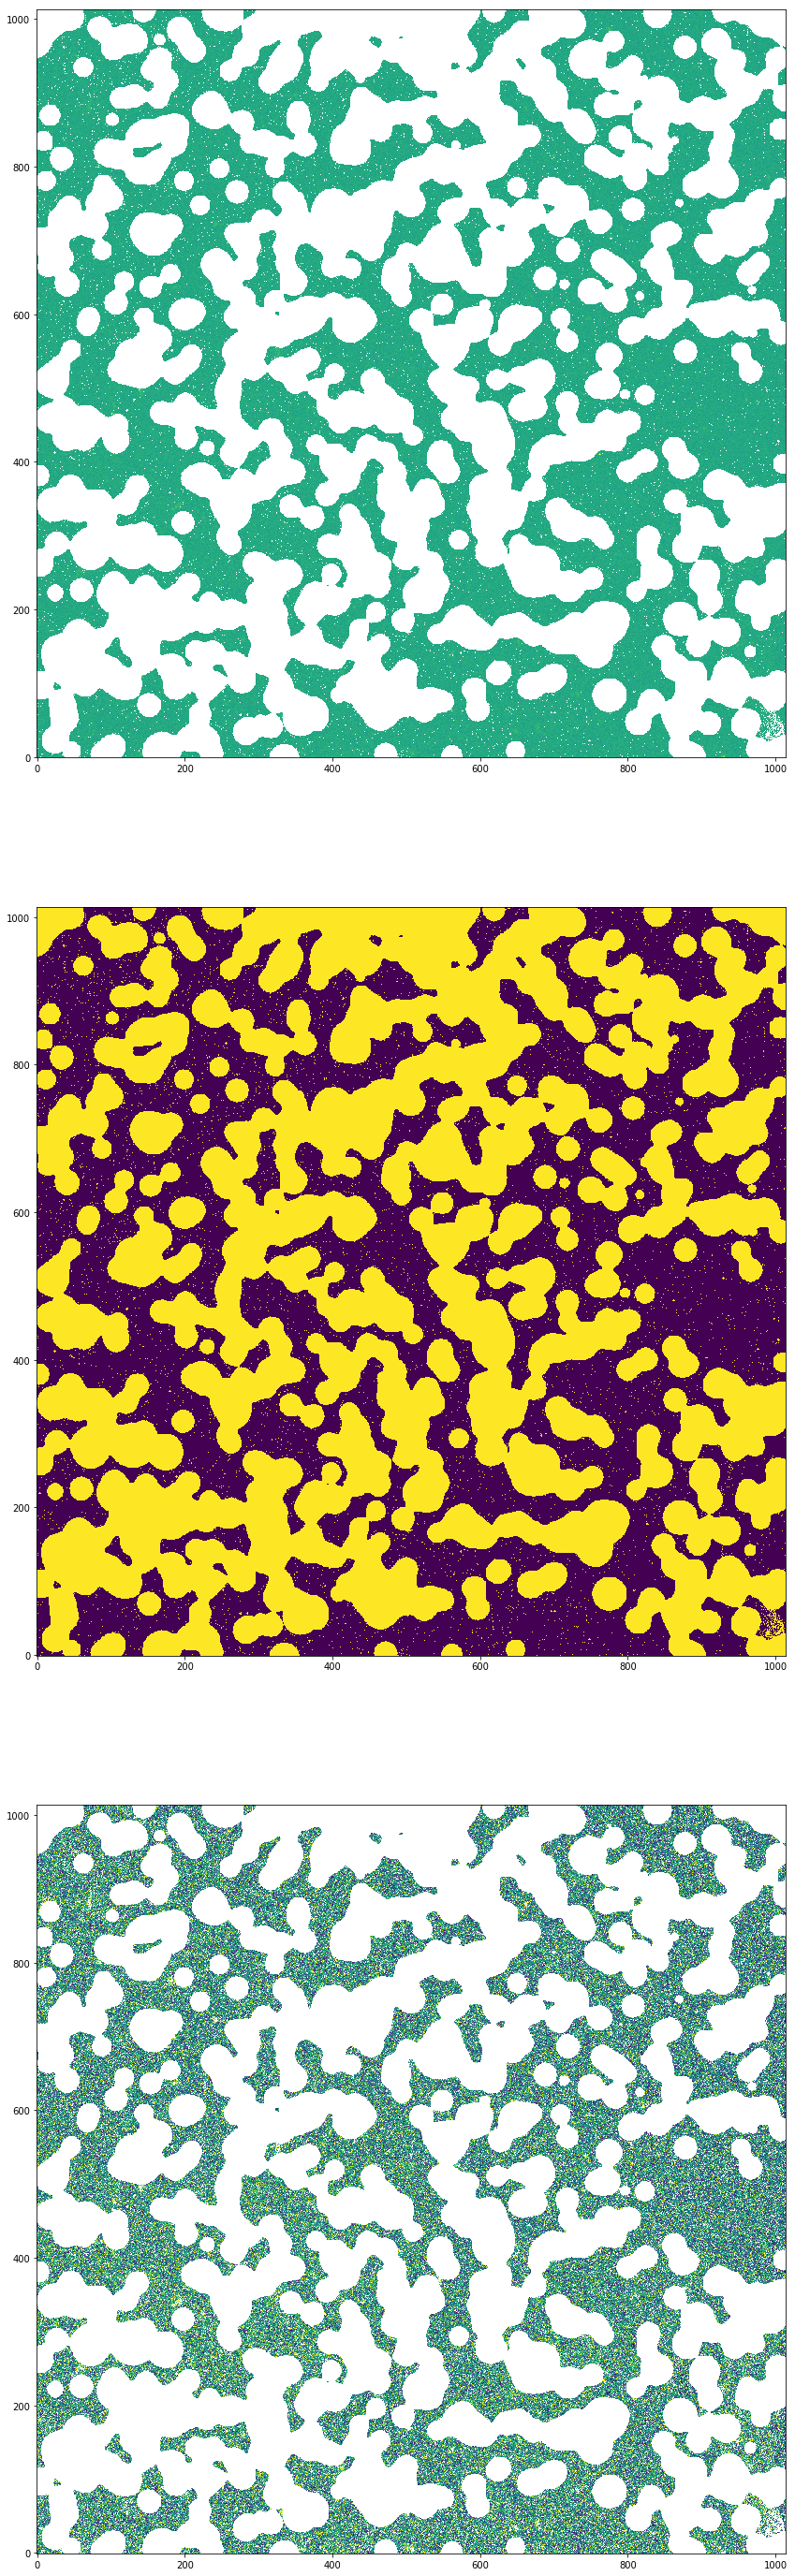

In [40]:
from astropy.stats import sigma_clip
clip_data = sigma_clip(data3, sigma=2, iters=3)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(50, 50))
ax1.imshow(data3, origin='lower')
ax2.imshow(z, origin='lower')
ax3.imshow(clip_data, origin='lower')

In [42]:
#z[~np.isnan]
nans = np.isnan(data3)

no_nans_data = data3[~nans]
#print(nans)
print(no_nans_data.size)
print(data3.size)
nan_size=no_nans_data.size
datsize=data3.size
if nan_size>(datsize*0.8):
    print("not enough data")
else:
    print("This should work")

469379
1028196
This should work
